In [ ]:
# !apt-get install poppler-utils tesseract-ocr libmagic-dev
# %pip install -Uq "unstructured[all-docs]" pillow lxml pillow
# %pip install -Uq chromadb tiktoken
# %pip install -Uq langchain langchain-community langchain-ollama langchain-huggingface
# %pip install -Uq python_dotenv sentence-transformers

In [1]:
import os

# Optional: LangChain tracing (still useful for debugging)
# os.environ["LANGCHAIN_API_KEY"] = "sk-..."  # Only if you want tracing
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

print("Setup complete! Make sure Ollama is installed and running.")
print("Required Ollama models:")
print("  ollama pull llama3.1:8b")
print("  ollama pull llava:7b")

Setup complete! Make sure Ollama is installed and running.
Required Ollama models:
  ollama pull llama3.1:8b
  ollama pull llava:7b


/Users/arnabchakraborty/Desktop/WrishavSett/multimodal-rag/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arnabchakraborty/Desktop/WrishavSett/multimodal-rag/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 3068.25it/s]
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


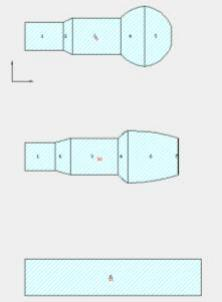

In [2]:
### Extract the data

## Partition PDF tables, text and images
from unstructured.partition.pdf import partition_pdf

output_path = "/Users/arnabchakraborty/Desktop/WrishavSett/multimodal-rag/"
file_path = output_path + 'NAGFORM_MANUAL.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

## Separate extracted elements into tables, text and images

# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

## Check what the images look like

import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [3]:
### Summarize data

## Text and table summaries using Ollama

from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt for text and table summarization
prompt_text = """
You are an assistant tasked with summarizing text.
Give a concise summary of the text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Text chunk: {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain using local Ollama Llama model
model = ChatOllama(
    model="llama3.1:8b",
    temperature=0.5,
    # Ollama runs locally, so we can set reasonable timeouts
    request_timeout=60.0
)

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

print("Summarizing text chunks...")
# Process texts in smaller batches to avoid overwhelming local model
batch_size = 2
text_summaries = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    batch_summaries = summarize_chain.batch(batch)
    text_summaries.extend(batch_summaries)
    print(f"Processed {min(i+batch_size, len(texts))}/{len(texts)} text chunks")

# print("Summarizing table chunks...")
# # Summarize tables
# tables_html = [table.metadata.text_as_html for table in tables]
# table_summaries = []
# for i in range(0, len(tables_html), batch_size):
#     batch = tables_html[i:i+batch_size]
#     batch_summaries = summarize_chain.batch(batch)
#     table_summaries.extend(batch_summaries)
#     print(f"Processed {min(i+batch_size, len(tables_html))}/{len(tables_html)} table chunks")

## Image summaries using Ollama LLaVA

# Prompt for image description
prompt_template = """Describe this image in detail. 
For context, this image is part of a user manual.
Be specific about the content you see.
Focus on the technical details and the overall functionality that would be useful for understanding this image."""

print("Summarizing images...")
# LLaVA model for vision tasks
vision_model = ChatOllama(
    model="llava:7b",
    temperature=0.3,  # Lower temperature for more consistent descriptions
    request_timeout=120.0  # Vision tasks may take longer
)

# Process images one by one (vision models are more resource intensive)
image_summaries = []
for i, image_b64 in enumerate(images):
    try:
        # Create messages for vision model
        messages = [
            {
                "role": "user", 
                "content": prompt_template,
                "images": [image_b64]  # LLaVA expects images in this format
            }
        ]
        
        # Get summary for this image
        summary = vision_model.invoke(messages)
        if hasattr(summary, 'content'):
            image_summaries.append(summary.content)
        else:
            image_summaries.append(str(summary))
        
        print(f"Processed image {i+1}/{len(images)}")
        
    except Exception as e:
        print(f"Error processing image {i+1}: {str(e)}")
        image_summaries.append(f"Error processing image: {str(e)}")

print("All summarization complete!")

Summarizing text chunks...
Processed 2/71 text chunks
Processed 4/71 text chunks
Processed 6/71 text chunks
Processed 8/71 text chunks
Processed 10/71 text chunks
Processed 12/71 text chunks
Processed 14/71 text chunks
Processed 16/71 text chunks
Processed 18/71 text chunks
Processed 20/71 text chunks
Processed 22/71 text chunks
Processed 24/71 text chunks
Processed 26/71 text chunks
Processed 28/71 text chunks
Processed 30/71 text chunks
Processed 32/71 text chunks
Processed 34/71 text chunks
Processed 36/71 text chunks
Processed 38/71 text chunks
Processed 40/71 text chunks
Processed 42/71 text chunks
Processed 44/71 text chunks
Processed 46/71 text chunks
Processed 48/71 text chunks
Processed 50/71 text chunks
Processed 52/71 text chunks
Processed 54/71 text chunks
Processed 56/71 text chunks
Processed 58/71 text chunks
Processed 60/71 text chunks
Processed 62/71 text chunks
Processed 64/71 text chunks
Processed 66/71 text chunks
Processed 68/71 text chunks
Processed 70/71 text chun

In [22]:
### Load data and summaries to vectorstore

## Create vector store with free embeddings

import uuid
import os
import shutil
from langchain_community.vectorstores import Chroma
from langchain.storage import InMemoryStore, LocalFileStore
from langchain.schema.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

def convert_element_to_document(element, content_type, index):
    """Convert unstructured elements to proper Document objects"""
    try:
        # Extract text content
        if hasattr(element, 'text'):
            content = str(element.text)
        elif hasattr(element, 'metadata') and hasattr(element.metadata, 'text_as_html'):
            content = str(element.metadata.text_as_html)
        else:
            content = str(element)
        
        # Create clean metadata dictionary
        metadata = {
            "content_type": content_type,
            "index": index,
            "source": f"original_{content_type}"
        }
        
        # Add specific metadata if available
        if hasattr(element, 'metadata'):
            element_meta = element.metadata
            if hasattr(element_meta, 'page_number'):
                metadata["page_number"] = element_meta.page_number
            if hasattr(element_meta, 'filename'):
                metadata["filename"] = str(element_meta.filename)
        
        return Document(page_content=content, metadata=metadata)
        
    except Exception as e:
        print(f"Warning: Could not convert element {index} to document: {e}")
        return Document(
            page_content=str(element), 
            metadata={
                "content_type": content_type,
                "index": index, 
                "source": f"fallback_{content_type}"
            }
        )

# Setup persistent storage
chroma_path = f"{output_path}chroma_db/"
if os.path.exists(chroma_path):
    print(f"Removing existing ChromaDB directory: {chroma_path}")
    shutil.rmtree(chroma_path)

# import tempfile

# # Create a temporary, writable directory for Chroma
# chroma_path = tempfile.mkdtemp(prefix="chroma_db_")
# print(f"Using temporary Chroma DB directory at: {chroma_path}")


print("Loading embedding model...")
embedding_model = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'mps'},
    encode_kwargs={'normalize_embeddings': True}
)

print("Creating vector store with disk persistence...")
vectorstore = Chroma(
    collection_name="multi_modal_rag", 
    embedding_function=embedding_model,
    persist_directory="./chroma_db/"
)

# The storage layer for the parent documents
# store = InMemoryStore()
docstore_path = f"{output_path}docstore/"
store = InMemoryStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

## Load the summaries and link them to the original data

print("Adding text summaries to vector store...")
try:
    if text_summaries and texts:
        doc_ids = [str(uuid.uuid4()) for _ in texts]
        
        # Create summary documents for vectorstore
        summary_texts = [
            Document(
                page_content=str(summary),
                metadata={
                    id_key: doc_ids[i],
                    "content_type": "text",
                    "chunk_index": i,
                    "source": "text_summary"
                }
            ) for i, summary in enumerate(text_summaries) if summary and str(summary).strip()
        ]
        
        # Convert original text elements to proper Document objects
        original_text_docs = [
            convert_element_to_document(text_element, "text", i) 
            for i, text_element in enumerate(texts)
        ]
        
        if summary_texts:
            retriever.vectorstore.add_documents(summary_texts)
            retriever.docstore.mset(list(zip(doc_ids, original_text_docs)))
            print(f"✓ Added {len(summary_texts)} text summaries")
        else:
            print("No valid text summaries to add")
            
except Exception as e:
    print(f"Error adding text summaries: {e}")

# print("Adding table summaries to vector store...")
# try:
#     if table_summaries and tables:
#         table_ids = [str(uuid.uuid4()) for _ in tables]
        
#         # Create summary documents for vectorstore
#         summary_tables = [
#             Document(
#                 page_content=str(summary),
#                 metadata={
#                     id_key: table_ids[i],
#                     "content_type": "table",
#                     "table_index": i,
#                     "source": "table_summary"
#                 }
#             ) for i, summary in enumerate(table_summaries) if summary and str(summary).strip()
#         ]
        
#         # Convert original table elements to proper Document objects
#         original_table_docs = [
#             convert_element_to_document(table_element, "table", i)
#             for i, table_element in enumerate(tables)
#         ]
        
#         if summary_tables:
#             retriever.vectorstore.add_documents(summary_tables)
#             retriever.docstore.mset(list(zip(table_ids, original_table_docs)))
#             print(f"✓ Added {len(summary_tables)} table summaries")
#         else:
#             print("No valid table summaries to add")
            
# except Exception as e:
#     print(f"Error adding table summaries: {e}")

print("Adding image summaries to vector store...")
try:
    if image_summaries and images:
        img_ids = [str(uuid.uuid4()) for _ in images]
        
        # Create summary documents for vectorstore  
        summary_img = [
            Document(
                page_content=str(summary),
                metadata={
                    id_key: img_ids[i],
                    "content_type": "image",
                    "image_index": i,
                    "source": "image_summary"
                }
            ) for i, summary in enumerate(image_summaries) if summary and str(summary).strip()
        ]
        
        # Create original image documents with base64 data
        original_img_docs = [
            Document(
                page_content=f"Image {i+1} from research paper (base64 encoded)",
                metadata={
                    "content_type": "image",
                    "image_index": i,
                    "image_base64": img_b64,
                    "source": "original_image"
                }
            ) for i, img_b64 in enumerate(images)
        ]
        
        if summary_img:
            retriever.vectorstore.add_documents(summary_img)
            retriever.docstore.mset(list(zip(img_ids, original_img_docs)))
            print(f"✓ Added {len(summary_img)} image summaries")
        else:
            print("No valid image summaries to add")
            
except Exception as e:
    print(f"Error adding image summaries: {e}")

print("Persisting vector store to disk...")
print(f"✓ Vector store saved to: {os.path.abspath(chroma_path)}")
print("Vector store setup complete!")

## Test retrieval with robust error handling

def safe_display_document(doc, index):
    """Safely display document information regardless of type"""
    print(f"\n--- Document {index+1} ---")
    
    try:
        if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
            # It's a proper Document object
            content_type = doc.metadata.get('content_type', 'unknown')
            source = doc.metadata.get('source', 'unknown')
            print(f"Type: {content_type} | Source: {source}")
            print(f"Content: {doc.page_content[:300]}...")
            
            # Special handling for images
            if content_type == "image" and "image_base64" in doc.metadata:
                print(f"[Contains base64 image data - {len(doc.metadata['image_base64'])} characters]")
                
        elif hasattr(doc, 'page_content'):
            # Document object without proper metadata
            print("Type: Document (no metadata)")
            print(f"Content: {doc.page_content[:300]}...")
            
        else:
            # Some other object type
            print(f"Type: {type(doc).__name__}")
            print(f"Content: {str(doc)[:300]}...")
            
    except Exception as e:
        print(f"Error displaying document: {e}")
        print(f"Raw content: {str(doc)[:200]}...")
    
    print("-" * 60)

Loading embedding model...
Creating vector store with disk persistence...
Adding text summaries to vector store...
✓ Added 71 text summaries
Adding image summaries to vector store...
✓ Added 171 image summaries
Persisting vector store to disk...
✓ Vector store saved to: /Users/arnabchakraborty/Desktop/WrishavSett/multimodal-rag/chroma_db
Vector store setup complete!


In [ ]:
# print("\nTesting retrieval...")
try:
    docs = retriever.invoke("explain advanced design helper")
    print(f"Retrieved {len(docs)} documents:")
    
    for i, doc in enumerate(docs):
        safe_display_document(doc, i)
        
except Exception as e:
    print(f"Error during retrieval: {e}")
    print("Trying direct vectorstore search...")
    try:
        direct_results = vectorstore.similarity_search("authors paper", k=3)
        print(f"Direct search found {len(direct_results)} results:")
        for i, result in enumerate(direct_results):
            safe_display_document(result, i)
    except Exception as e2:
        print(f"Direct search also failed: {e2}")

## Test multiple queries
print("\nTesting additional queries...")
test_queries = [
    "attention mechanism",
    "transformer architecture", 
    "experimental results"
]

for query in test_queries:
    try:
        print(f"\n🔍 Query: '{query}'")
        results = retriever.invoke(query)
        print(f"Found {len(results)} results")
        
        if results:
            first_result = results[0]
            if hasattr(first_result, 'page_content'):
                preview = first_result.page_content[:100]
                content_type = getattr(first_result.metadata, 'content_type', 'unknown') if hasattr(first_result, 'metadata') else 'unknown'
                print(f"Preview ({content_type}): {preview}...")
            else:
                print(f"Preview: {str(first_result)[:100]}...")
                
    except Exception as e:
        print(f"Error with query '{query}': {e}")

print(f"\n✅ Setup complete! Your multimodal RAG system is ready!")
print(f"📁 Vector database persisted at: {os.path.abspath(chroma_path)}")
print(f"📊 Total documents in store: {len(retriever.docstore.store) if hasattr(retriever.docstore, 'store') else 'Unknown'}")

Retrieved 4 documents:

--- Document 1 ---
Type: text | Source: original_text
Content: 6.2. Menu Selection ‘Getting Too Many Designs’

When this selection is made, the following dialog box comes up.

- Limits On Blank Diamter : Rules Past ID: | @ Reset to before chan From: [5.000000 To: fo.oo000 EWE DEr Tighten Design Rules by: [o.oo x Save changed rules > Limits On Number of Operatio...
------------------------------------------------------------

--- Document 2 ---
Type: text | Source: original_text
Content: 6. Advanced Design Helper

___________________________________________________________________________________

In NAGFORM, the main menu has a separate title ‘Design Helper’ as shown below.

NAGFORM: Program for Metal Forming Analysis and Design File Edit Model Material | Desien Helper Machine Dime...
------------------------------------------------------------

--- Document 3 ---
Type: text | Source: original_text
Content: 2.2.4 Help

Help menu has three selections:

• Version 